In [107]:
import torch
import numpy as np 
import pandas as pd
import os

In [108]:
data_path = '/kaggle/input/google-stock-price/GOOG.csv'

In [109]:
dataset = pd.read_csv(data_path)

In [110]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [111]:
import matplotlib.pyplot as plt

In [112]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values('Date')

In [113]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


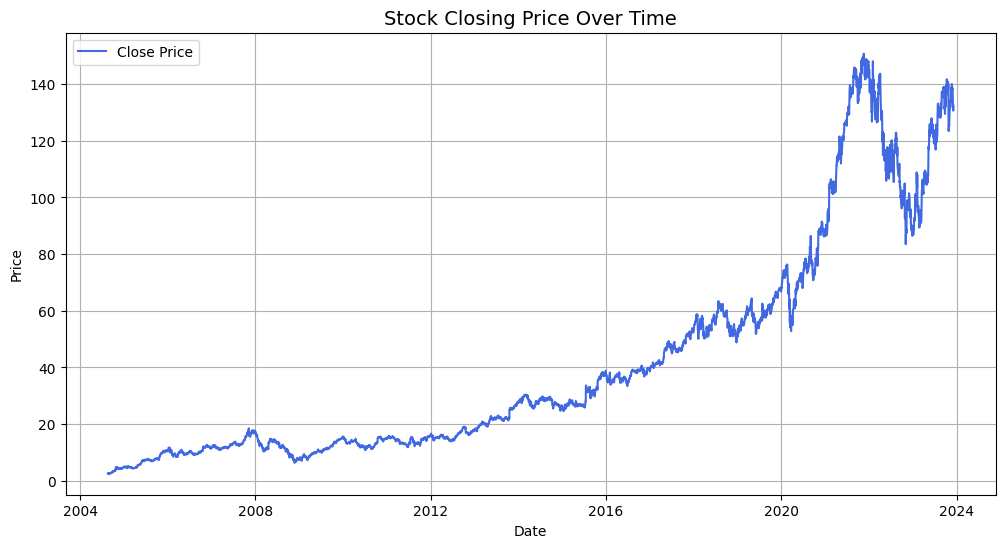

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Close'], label='Close Price', color='royalblue')
plt.title('Stock Closing Price Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


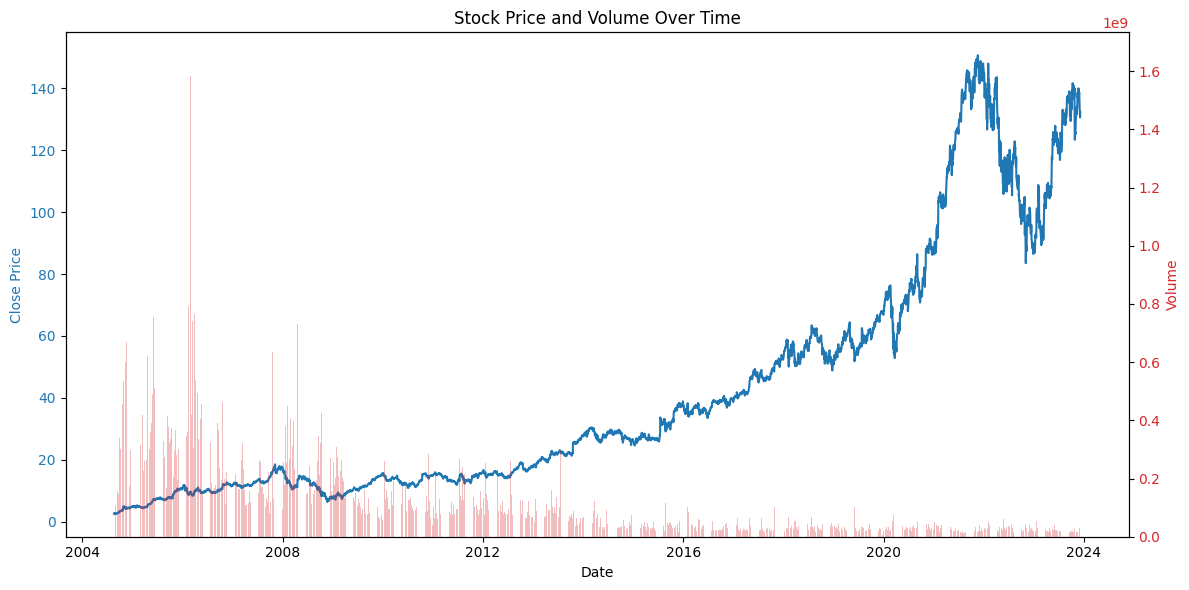

In [115]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(dataset['Date'], dataset['Close'], color=color, label='Close')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Volume', color=color)
ax2.bar(dataset['Date'],dataset['Volume'], color=color, alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Stock Price and Volume Over Time')
fig.tight_layout()
plt.show()

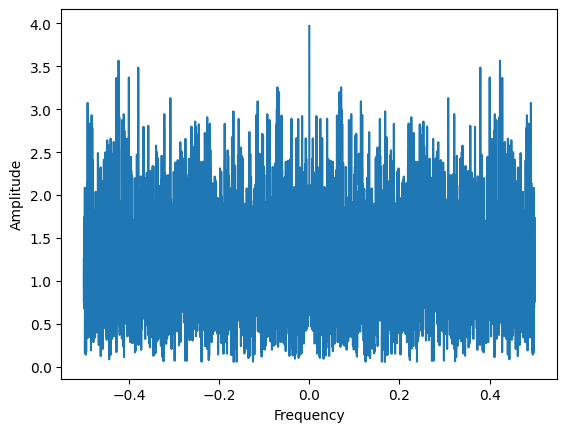

In [116]:
y = np.diff(np.log(dataset['Close'].values))
fft_values = np.fft.fft(y)
n = len(y)
amplitudes = np.abs(fft_values)
freqs = np.fft.fftfreq(n, d=1)
plt.plot(freqs, amplitudes)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

In [117]:
positive_freq_mask = freqs > 0
positive_freqs = freqs[positive_freq_mask]
positive_amplitudes = amplitudes[positive_freq_mask]

top_indices = np.argsort(positive_amplitudes)[-15:][::-1]
top_freqs = positive_freqs[top_indices]
top_amps = positive_amplitudes[top_indices]

top_periods = 1 / top_freqs 

print("Top 10 Dominant Cycles in Google Stock Returns:")
print("="*50)
for i, (freq, amp, period) in enumerate(zip(top_freqs, top_amps, top_periods), 1):
    print(f"{i}. Frequency: {freq:.4f} | Period: {period:.1f} days | Amplitude: {amp:.2f}")

Top 10 Dominant Cycles in Google Stock Returns:
1. Frequency: 0.4229 | Period: 2.4 days | Amplitude: 3.57
2. Frequency: 0.4227 | Period: 2.4 days | Amplitude: 3.52
3. Frequency: 0.3792 | Period: 2.6 days | Amplitude: 3.48
4. Frequency: 0.4000 | Period: 2.5 days | Amplitude: 3.37
5. Frequency: 0.4278 | Period: 2.3 days | Amplitude: 3.36
6. Frequency: 0.0706 | Period: 14.2 days | Amplitude: 3.25
7. Frequency: 0.4233 | Period: 2.4 days | Amplitude: 3.21
8. Frequency: 0.0671 | Period: 14.9 days | Amplitude: 3.20
9. Frequency: 0.3080 | Period: 3.2 days | Amplitude: 3.13
10. Frequency: 0.1145 | Period: 8.7 days | Amplitude: 3.09
11. Frequency: 0.4915 | Period: 2.0 days | Amplitude: 3.07
12. Frequency: 0.4250 | Period: 2.4 days | Amplitude: 3.07
13. Frequency: 0.0719 | Period: 13.9 days | Amplitude: 3.00
14. Frequency: 0.1682 | Period: 5.9 days | Amplitude: 2.97
15. Frequency: 0.3214 | Period: 3.1 days | Amplitude: 2.94


In [118]:
df = dataset.copy()
df['Returns'] = np.log(df['Close']).diff()
df = df.dropna()

In [119]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,0.076433
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,0.010013
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,-0.042289
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,0.010717
5,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401,0.017859


In [120]:
def create_features(df, top_freqs, lookback=5):
    features = pd.DataFrame(index=df.index)

    t = np.arange(len(df))
    for i, freq in enumerate(top_freqs[:5]):
        features[f'sin_{i}'] = np.sin(2*np.pi*freq*t)
        features[f'cos_{i}'] = np.cos(2*np.pi*freq*t)
    
    for lag in range(1, lookback+1):
        features[f'log_{lag}'] = df["Returns"].shift(lag)

    features['ma_5'] = df['Returns'].rolling(5).mean()
    features['ma_20'] = df['Returns'].rolling(20).mean()
    features['vol_5'] = df['Returns'].rolling(5).std()
    return features

In [121]:
features = create_features(df, top_freqs)

In [122]:
target = df['Returns'].shift(-1)
valid_idx = features.dropna().index.intersection(target.dropna().index)

In [123]:
features = features.loc[valid_idx]
target = target.loc[valid_idx]


In [124]:
split_idx = int(len(features) * 0.8)
X_train, X_test = features[:split_idx], features[split_idx:]
y_train, y_test = target[:split_idx], target[split_idx:]

In [125]:
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")

Training samples: 3869
Testing samples: 968
Features: 18


In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [127]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [128]:
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [129]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

In [130]:
print(f"Train RMSE: {train_rmse:.6f}")
print(f"Test RMSE:  {test_rmse:.6f}")
print(f"Test MAE:   {test_mae:.6f}")


Train RMSE: 0.015628
Test RMSE:  0.021498
Test MAE:   0.015270


In [133]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

In [134]:
print("TOP 10 FEATURES")
print(feature_importance.head(10))

TOP 10 FEATURES
   feature  importance
15    ma_5    0.117905
14   log_5    0.095908
16   ma_20    0.093529
13   log_4    0.066640
10   log_1    0.065335
7    cos_3    0.065108
6    sin_3    0.052572
17   vol_5    0.051287
2    sin_1    0.047228
12   log_3    0.046313


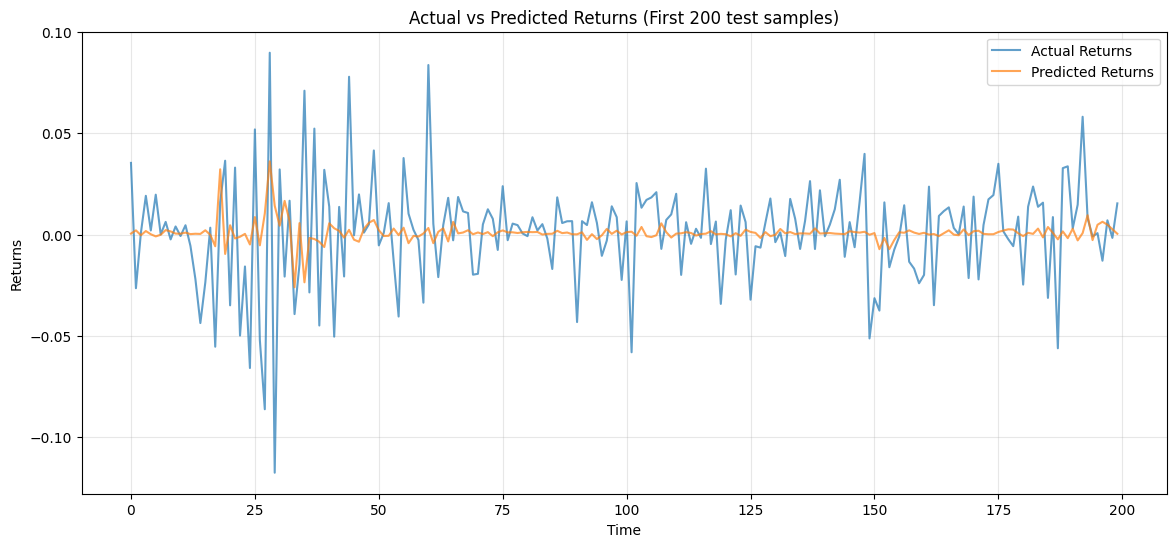

In [135]:
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label='Actual Returns', alpha=0.7)
plt.plot(y_pred_test[:200], label='Predicted Returns', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Actual vs Predicted Returns (First 200 test samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [136]:
baseline_pred = np.zeros(len(y_test))
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f"Baseline RMSE: {baseline_rmse:.6f}")
print(f"Our Model RMSE: {test_rmse:.6f}")
print(f"Improvement: {((baseline_rmse - test_rmse) / baseline_rmse * 100):.2f}%")

Baseline RMSE: 0.021340
Our Model RMSE: 0.021498
Improvement: -0.74%


In [137]:
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [139]:
SX=StandardScaler()
SY=StandardScaler()

SX_train=SX.fit_transform(X_train)
SX_test=SX.transform(X_test)
SY_train=SY.fit_transform(y_train.values.reshape(-1, 1))
SY_test=SY.transform(y_test.values.reshape(-1,1))

In [172]:
def create_seq(X,y,seq_length):
    Xs,Ys=[],[]
    for i in range(len(X)-seq_length):
        Xs.append(X[i:i+seq_length])
        Ys.append(y[i+seq_length])
    return np.array(Xs), np.array(Ys)

In [173]:
seq_length=10

x_train_seq, y_train_seq = create_seq(SX_train, SY_train, seq_length)
x_test_seq, y_test_seq = create_seq(SX_test, SY_test, seq_length)

In [174]:
print(f"Training sequences: {x_train_seq.shape}")
print(f"Testing sequences: {x_test_seq.shape}")

Training sequences: (3859, 10, 18)
Testing sequences: (958, 10, 18)


In [175]:
class StockDataset(Dataset):
    def __init__(self, X ,y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [176]:
train_dataset = StockDataset(x_train_seq, y_train_seq)
test_dataset = StockDataset(x_test_seq, y_test_seq)

In [177]:
batch_size=32
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [178]:
class SLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(SLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers =num_layers 

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = dropout
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = lstm_out[:,-1,:]
        out = self.fc1(output)
        out = self.relu(out)
        out=self.fc2(out)
        return out

In [179]:
input_size = X_train.shape[1]  # Number of features
model = SLSTM(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)
model = model.to(device)

In [180]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [181]:
train_losses=[]
model.train()
for epoch in range(50):
    train_loss=0
    for x,y in train_loader:
        x, y = x.to(device), y.to(device)
        output= model(x)
        optimizer.zero_grad()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch: {epoch+1}, LOSS: {avg_loss}")

Epoch: 1, LOSS: 0.9958178174705052
Epoch: 2, LOSS: 0.9946369544164209
Epoch: 3, LOSS: 0.9912704649912424
Epoch: 4, LOSS: 0.9837682799797905
Epoch: 5, LOSS: 0.9687170279481687
Epoch: 6, LOSS: 0.9491082605374747
Epoch: 7, LOSS: 0.9297833441456488
Epoch: 8, LOSS: 0.903778794998965
Epoch: 9, LOSS: 0.8845877535949068
Epoch: 10, LOSS: 0.8846094929728626
Epoch: 11, LOSS: 0.8661243225917343
Epoch: 12, LOSS: 0.8475431954441977
Epoch: 13, LOSS: 0.8280676685827822
Epoch: 14, LOSS: 0.8015224913920252
Epoch: 15, LOSS: 0.7852907964636472
Epoch: 16, LOSS: 0.7640803689060133
Epoch: 17, LOSS: 0.7385082340930119
Epoch: 18, LOSS: 0.7255390643580886
Epoch: 19, LOSS: 0.701681572420538
Epoch: 20, LOSS: 0.676099731040395
Epoch: 21, LOSS: 0.6403783583813463
Epoch: 22, LOSS: 0.6174925983198418
Epoch: 23, LOSS: 0.6027716750448401
Epoch: 24, LOSS: 0.5912214916599684
Epoch: 25, LOSS: 0.5679624414394709
Epoch: 26, LOSS: 0.5489401208960321
Epoch: 27, LOSS: 0.5374708726140093
Epoch: 28, LOSS: 0.5165884640098604
Epoc

In [182]:
test_losses=[]
model.eval()
for epoch in range(50):
    test_loss=0
    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.to(device), y.to(device)
            output= model(x)
            loss = criterion(output, y)
            test_loss += loss.item()
    avg_loss = test_loss/len(test_loader)
    test_losses.append(avg_loss)
    print(f"Epoch: {epoch+1}, LOSS: {avg_loss}")

Epoch: 1, LOSS: 1.8814664274454116
Epoch: 2, LOSS: 1.8814664274454116
Epoch: 3, LOSS: 1.8814664274454116
Epoch: 4, LOSS: 1.8814664274454116
Epoch: 5, LOSS: 1.8814664274454116
Epoch: 6, LOSS: 1.8814664274454116
Epoch: 7, LOSS: 1.8814664274454116
Epoch: 8, LOSS: 1.8814664274454116
Epoch: 9, LOSS: 1.8814664274454116
Epoch: 10, LOSS: 1.8814664274454116
Epoch: 11, LOSS: 1.8814664274454116
Epoch: 12, LOSS: 1.8814664274454116
Epoch: 13, LOSS: 1.8814664274454116
Epoch: 14, LOSS: 1.8814664274454116
Epoch: 15, LOSS: 1.8814664274454116
Epoch: 16, LOSS: 1.8814664274454116
Epoch: 17, LOSS: 1.8814664274454116
Epoch: 18, LOSS: 1.8814664274454116
Epoch: 19, LOSS: 1.8814664274454116
Epoch: 20, LOSS: 1.8814664274454116
Epoch: 21, LOSS: 1.8814664274454116
Epoch: 22, LOSS: 1.8814664274454116
Epoch: 23, LOSS: 1.8814664274454116
Epoch: 24, LOSS: 1.8814664274454116
Epoch: 25, LOSS: 1.8814664274454116
Epoch: 26, LOSS: 1.8814664274454116
Epoch: 27, LOSS: 1.8814664274454116
Epoch: 28, LOSS: 1.8814664274454116
E

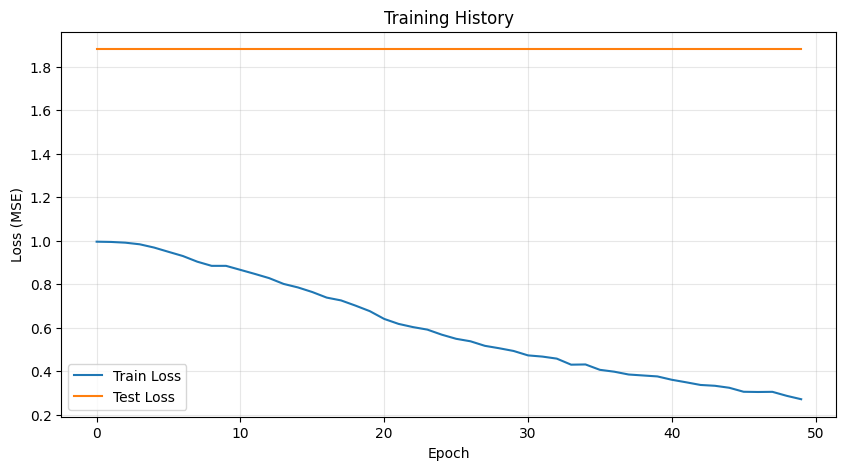

In [183]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [185]:
model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        all_preds.append(output.cpu().numpy())
        all_actuals.append(y.cpu().numpy())

# Concatenate and inverse transform
y_pred_scaled = np.concatenate(all_preds)
y_actual_scaled = np.concatenate(all_actuals)

y_pred = SY.inverse_transform(y_pred_scaled)
y_actual = SY.inverse_transform(y_actual_scaled)

# Calculate RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"\nLSTM RMSE: {lstm_rmse:.6f}")
print(f"Baseline RMSE: 0.021340")
print(f"Random Forest RMSE: 0.021498")


LSTM RMSE: 0.025598
Baseline RMSE: 0.021340
Random Forest RMSE: 0.021498
